# Kinematics Analysis

In [1]:
from cyto.postprocessing.graph import *
from cyto.utils.label_to_table import *
import dask_image.imread
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
import pyclesperanto_prototype as cle
import pandas as pd

### Load ultrack mapped, area-sized filtered and track_length pre-filtered tracks or signal mapped dataframes from example 5 

In [2]:
tracks_df_filtered_tcell = pd.read_csv("/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/tracks/tcell_tracks/tracks/tcell_tracks_filtered.csv")
tracks_df_filtered_cancer = pd.read_csv("/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/tracks/cancer_tracks/tracks/cancer_tracks_filtered.csv")
tracks_df_filtered_tcell.drop("Unnamed: 0", axis=1, inplace=True)
tracks_df_filtered_cancer.drop("Unnamed: 0", axis=1, inplace=True)

# Perform Kinematics Calculations

## T Cells

In [46]:
# # displacement
diff = tracks_df_filtered_tcell.groupby("track_id")[["x","y","frame"]].diff()
tracks_df_filtered_tcell["dx from previous point"] = diff["x"].fillna(0)
tracks_df_filtered_tcell["dy from previous point"] = diff["y"].fillna(0)
tracks_df_filtered_tcell["displacement from previous point"] = np.linalg.norm(tracks_df_filtered_tcell[["dx from previous point","dy from previous point"]], axis=1)

tracks_df_filtered_tcell["dx from origin"] = tracks_df_filtered_tcell.groupby(['track_id'])['dx from previous point'].cumsum().fillna(0)
tracks_df_filtered_tcell["dy from origin"] = tracks_df_filtered_tcell.groupby(['track_id'])['dy from previous point'].cumsum().fillna(0)
tracks_df_filtered_tcell["displacement from origin"] = np.linalg.norm(tracks_df_filtered_tcell[["dx from origin","dy from origin"]], axis=1)
tracks_df_filtered_tcell["dx acc"] = diff["x"].apply(lambda x: abs(x)).fillna(0) # abs displacement
tracks_df_filtered_tcell["dy acc"] = diff["y"].apply(lambda x: abs(x)).fillna(0) # abs displacement
tracks_df_filtered_tcell["dx acc"] = tracks_df_filtered_tcell.groupby(['track_id'])['dx acc'].cumsum()
tracks_df_filtered_tcell["dy acc"] = tracks_df_filtered_tcell.groupby(['track_id'])['dy acc'].cumsum()
tracks_df_filtered_tcell["distance travelled"] = tracks_df_filtered_tcell.groupby(['track_id'])['displacement from previous point'].cumsum()


# velocity
tracks_df_filtered_tcell["vel_x"] = (diff["x"]/diff["frame"]).fillna(0)
tracks_df_filtered_tcell["vel_y"] = (diff["y"]/diff["frame"]).fillna(0)
tracks_df_filtered_tcell["speed"] = (np.linalg.norm(diff[["x","y"]], axis=1)/diff['frame']).fillna(0)
tracks_df_filtered_tcell["speed acc"] = tracks_df_filtered_tcell.groupby(['track_id'])['speed'].cumsum().fillna(0)
# TODO: Track tortuosity

tracks_df_filtered_tcell

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,mean,median,sd,frame,channel,alive,pi_mean,pi_median,pi_std,corr_mean,corr_median,corr_std,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,dx from previous point,dy from previous point,displacement from previous point,dx from origin,dy from origin,displacement from origin,dx acc,dy acc,distance travelled,vel_x,vel_y,speed,average speed,speed acc
0,9161,21.000000,1.181818,0,18,4,7,1.181818,21.000000,0.0,18.0,4.0,7.0,22.0,1.709349,1.709349,0.948756,6.082763,3.041381,17.525146,150757.0,6852.590909,6951.439453,1049.450181,0,tcell,NaN,2861.818182,2904.599609,44.300528,32780.045455,32905.679688,2.951630,1,1000002,0.181818,162,162,22.043210,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
1,420,46.549180,6.090164,0,40,14,13,6.090164,46.549180,0.0,40.0,14.0,13.0,122.0,1.316214,1.316214,0.835087,14.317821,7.158911,46.887080,1050057.0,8607.024590,8649.513672,1176.360900,0,tcell,NaN,3326.786885,3160.279297,445.091303,32858.754098,32905.679688,123.740619,4,1000016,2.544339,142,145,59.725352,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.185721,0.000000
2,1935,61.300000,11.933333,8,57,9,9,11.933333,61.300000,8.0,57.0,9.0,9.0,60.0,1.153715,1.153715,0.960884,9.219544,4.609772,28.576536,556612.0,9276.866667,8649.513672,2665.723602,0,tcell,NaN,2944.750000,2904.599609,54.361198,32763.733333,32650.320312,11.338948,6,1000019,0.307318,134,134,53.768657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.742700,0.000000
3,700,57.642105,5.000000,0,53,13,11,5.000000,57.642105,0.0,53.0,13.0,11.0,95.0,1.491018,1.491018,0.859847,13.892444,6.946222,40.183288,865409.0,9109.568421,8892.095703,1923.757127,0,tcell,NaN,2943.631579,2904.599609,93.777697,32769.305263,32650.320312,11.074288,9,1000021,0.357895,57,57,46.614035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.761165,0.000000
4,9496,95.000000,1.500000,0,93,4,5,1.500000,95.000000,0.0,93.0,4.0,5.0,20.0,1.264911,1.264911,0.993667,5.000000,2.500000,15.954349,171145.0,8557.250000,8406.931641,945.097537,0,tcell,NaN,3793.400000,3799.478516,271.456578,33130.250000,33161.039062,155.747730,10,1000024,0.500000,25,28,35.440000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330685,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13907692,16874279,956.115385,884.653846,882,954,6,5,884.653846,956.115385,882.0,954.0,6.0,5.0,26.0,1.410760,1.410760,0.999726,6.403124,3.201562,18.080506,169739.0,6528.423077,6448.203125,758.167115,1999,tcell,NaN,3036.730769,3096.410156,54.567798,32785.730769,32837.123047,2.706403,294749,2000028684,0.364878,21,21,27.952381,0.024217,-0.254986,0.256133,-3.531339,-0.625356,3.586283,6.289993,4.042151,8.451728,0.024217,-0.254986,0.256133,NaN,8.451728
13907693,16868621,707.091398,905.274194,900,697,12,23,905.274194,707.091398,900.0,697.0,12.0,23.0,186.0,1.972999,1.972999,0.783177,22.203603,11.101802,61.730709,1610400.0,8658.064516,8632.109375,2089.361471,1999,tcell,NaN,11097.741935,10911.558594,4363.862613,34335.516129,33377.259766,1976.123303,294754,2000028754,2.448982,12,21,89.750000,3.448107,-8.147733,8.847315,-1.001397,-5.184193,5.280024,9.190964,14.999987,18.678282,3.448107,-8.147733,8.847315,NaN,16.462638
13907694,16870119,979.507463,966.477612,962,976,10,8,966.477612,979.507463,962.0,976.0,10.0,8.0,67.0,1.283351,1.283351,0.959451,10.000000,5.000000,30.242618,751030.0,11209.402985,10330.7

## Cancer Cells

In [45]:
# # displacement
diff_cancer = tracks_df_filtered_cancer.groupby("track_id")[["x","y","frame"]].diff()
tracks_df_filtered_cancer["dx from previous point"] = diff_cancer["x"].fillna(0)
tracks_df_filtered_cancer["dy from previous point"] = diff_cancer["y"].fillna(0)
tracks_df_filtered_cancer["displacement from previous point"] = np.linalg.norm(tracks_df_filtered_cancer[["dx from previous point","dy from previous point"]], axis=1)

tracks_df_filtered_cancer["dx from origin"] = tracks_df_filtered_cancer.groupby(['track_id'])['dx from previous point'].cumsum().fillna(0)
tracks_df_filtered_cancer["dy from origin"] = tracks_df_filtered_cancer.groupby(['track_id'])['dy from previous point'].cumsum().fillna(0)
tracks_df_filtered_cancer["displacement from origin"] = np.linalg.norm(tracks_df_filtered_cancer[["dx from origin","dy from origin"]], axis=1)
tracks_df_filtered_cancer["dx acc"] = diff_cancer["x"].apply(lambda x: abs(x)).fillna(0) # abs displacement
tracks_df_filtered_cancer["dy acc"] = diff_cancer["y"].apply(lambda x: abs(x)).fillna(0) # abs displacement
tracks_df_filtered_cancer["dx acc"] = tracks_df_filtered_cancer.groupby(['track_id'])['dx acc'].cumsum()
tracks_df_filtered_cancer["dy acc"] = tracks_df_filtered_cancer.groupby(['track_id'])['dy acc'].cumsum()
tracks_df_filtered_cancer["distance travelled"] = tracks_df_filtered_cancer.groupby(['track_id'])['displacement from previous point'].cumsum()


# velocity
tracks_df_filtered_cancer["vel_x"] = (diff_cancer["x"]/diff_cancer["frame"]).fillna(0)
tracks_df_filtered_cancer["vel_y"] = (diff_cancer["y"]/diff_cancer["frame"]).fillna(0)
tracks_df_filtered_cancer["speed"] = (np.linalg.norm(diff_cancer[["x","y"]], axis=1)/diff_cancer['frame']).fillna(0)


# TODO: Track tortuosity

tracks_df_filtered_cancer

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,mean,median,sd,frame,channel,alive,pi_mean,pi_median,pi_std,corr_mean,corr_median,corr_std,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,dx from previous point,dy from previous point,displacement from previous point,dx from origin,dy from origin,displacement from origin,dx acc,dy acc,distance travelled,vel_x,vel_y,speed,speed acc
0,750,47.236686,4.218935,0,38,12,22,4.218935,47.236686,0.0,38.0,12.0,22.0,169.0,1.624887,1.624887,0.854730,21.023796,10.511898,53.916196,1218332.0,7209.065089,6571.154297,2821.994518,0,cancer,NaN,3245.497041,3160.279297,405.286805,32835.147929,32650.320312,112.348398,1,1000015,0.322417,1412,1417,172.315864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,338,39.313846,20.772308,11,30,21,20,20.772308,39.313846,11.0,30.0,21.0,20.0,325.0,1.188168,1.188168,0.975334,22.203603,11.101802,65.522947,1703787.0,5242.421538,5108.255859,1304.145831,0,cancer,NaN,2910.606154,2904.599609,173.434119,32757.003077,32650.320312,13.057210,2,1000016,0.387741,250,250,257.560000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2,644,68.674641,6.401914,0,61,16,17,6.401914,68.674641,0.0,61.0,16.0,17.0,209.0,1.196962,1.196962,0.891607,19.416488,9.708244,57.478396,1984814.0,9496.717703,9496.951172,4114.656451,0,cancer,NaN,2893.162679,2904.599609,109.183210,32737.842105,32650.320312,46.478686,3,1000065,0.517101,267,268,182.782772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
3,443,103.872792,7.696113,0,94,17,20,7.696113,103.872792,0.0,94.0,17.0,20.0,283.0,1.290988,1.290988,0.912008,24.083189,12.041595,65.388194,2777222.0,9813.505300,10716.033203,3616.993614,0,cancer,NaN,3379.996466,3288.119141,386.760344,32876.250883,32905.679688,137.732668,4,1000067,0.329438,68,72,323.205882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
4,534,99.112000,20.592000,14,88,16,26,20.592000,99.112000,14.0,88.0,16.0,26.0,250.0,2.114153,2.114153,0.838271,25.709920,12.854960,66.863705,2376799.0,9507.196000,10228.400391,3229.740306,0,cancer,NaN,3452.620000,3288.119141,533.552024,32887.816000,32905.679688,179.961258,5,1000068,0.423093,101,120,291.039604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224215,2604466,69.923664,422.412214,413,65,18,11,422.412214,69.923664,413.0,65.0,18.0,11.0,131.0,1.811760,1.811760,0.901811,17.262677,8.631338,44.990961,857260.0,6543.969466,5954.847656,2868.757383,1999,cancer,NaN,4286.778626,4121.347656,693.183917,32782.778626,32729.095703,56.724746,31996,2000004515,11.642913,20,21,117.350000,-10.271184,-11.983672,15.783080,-11.887786,-15.247764,19.334264,24.418200,17.105910,31.572141,-5.135592,-5.991836,7.891540,1.059444e+06
2224216,2603825,716.931478,622.372591,609,706,27,26,622.372591,716.931478,609.0,706.0,27.0,26.0,467.0,1.167903,1.167903,0.926058,27.784888,13.892444,82.722770,4510565.0,9658.597430,7179.175781,5970.504923,1999,cancer,NaN,4891.627409,4633.816406,1388.669377,33012.182013,32837.123047,299.460185,32004,2000006405,0.631140,21,21,505.238095,-0.064647,0.017252,0.066910,-0.715363,0.564365,0.911182,1.578756,1.286890,2.233511,-0.064647,0.017252,0.066910,1.059444e+06
2224217,2604680,385.129870,608.363636,604,381,10,9,608.363636,385.129870,604.0,381.0,10.0,9.0,77.0,1.095464,1.095464,1.002527,9.899495,4.949747,31.028016,256479.0,

### Calculate MSD for displacement from origin

In [5]:
msd_df = tracks_df_filtered_tcell
msd_df["dt acc"] = tracks_df_filtered_tcell.groupby(['track_id'])['frame'].transform("min")
msd_df["dt acc"]  = msd_df["frame"] - msd_df["dt acc"]
msd_df.sort_values(by=["track_id","frame"])[["track_id","frame","dt acc"]]

#sanity check for a particular track_id
track_check = 80
msd_df[msd_df["track_id"]==track_check][["track_id","frame","displacement from origin","dt acc"]]

,track_id,frame,displacement from origin,dt acc
179954,80,22,0.000000,0
188746,80,23,0.427147,1
197567,80,24,0.615727,2
206379,80,25,1.363713,3
215171,80,26,1.609045,4
...,...,...,...,...
1473640,80,172,5.740793,150
1482177,80,173,5.489553,151
1490683,80,174,5.678340,152
1499191,80,175,5.265479,153


dt acc
0         0.000000
1         1.333644
2         2.189656
3         3.084615
4         3.884799
           ...    
1995    190.281946
1996    189.881064
1997    190.828440
1998    191.567853
1999    193.362262
Name: squared displacement from origin, Length: 2000, dtype: float64 dt acc
0         0.000000
1         7.397834
2         9.037389
3        10.555545
4        12.325770
           ...    
1995    273.943132
1996    274.182166
1997    274.741876
1998    276.665079
1999    277.565259
Name: squared displacement from origin, Length: 2000, dtype: float64


(0.0, 1000.0)

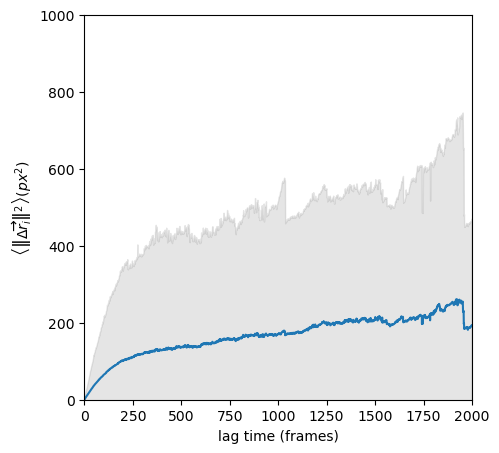

In [6]:
msd_df_ = msd_df
msd_df_["squared displacement from origin"] = msd_df_["displacement from origin"].apply(lambda x: x*x)
msd = msd_df_.groupby("dt acc")["squared displacement from origin"].mean()
msd_sd = msd_df_.groupby("dt acc")["squared displacement from origin"].std()
#single_tcell_df = msd_df_.loc[msd_df_["track_id"]==TRACK_ID_TCELL]

print(msd, msd_sd)
# track_id = 100

fig, axs = plt.subplots(1,1,figsize=(5,5))
msd.plot(
    ax=axs,
    xlabel="lag time (frames)",
    ylabel=r'$\left\langle \left\| \Delta \overrightarrow{r}_i \right\|^2 \right\rangle (px^2)$'
    )
axs.fill_between(np.arange(len(msd_sd)),msd-msd_sd,msd+msd_sd, color='gray', alpha=0.2, label='Std Dev')
axs.set_xlim([0,2000])
axs.set_ylim([0,1000])

#axs.set_yscale("log")
#axs.set_xscale("log")

### Calculate MSD for consecutive points in space 

In [7]:
msd_df_data = tracks_df_filtered_tcell[["label","x","y","track_id", "frame", "dx from previous point", "dy from previous point", "displacement from previous point"]]

msd_df_data = msd_df_data.sort_values(by=["track_id","frame"])
msd_results = pd.DataFrame(columns=["track_id", "dt", "msd"])

for t_id in tqdm(range(100,200)):
    #print(t_id)
    curr_track = msd_df_data.loc[msd_df_data["track_id"]==t_id]
    dt_array=[]
    if int(len(curr_track["frame"]))>0:
        #for dt in tqdm(np.logspace(0,100/int(len(curr_track["frame"])*0.7),num=30, base=10)):
        for dt in tqdm(range(1,int(len(curr_track["frame"])*0.7))):
            sd=[]
            dt=int(dt)
            #dt_array.append(dt)
            for t in range(len(curr_track["frame"])-int(dt)):
                #print(t, dt)
                try:
                    dx=(curr_track.loc[curr_track["frame"]==(t+dt),'x'].values[0]- curr_track.loc[curr_track["frame"]==t,'x'].values[0])**2
                    dy =(curr_track.loc[curr_track["frame"]==(t+dt),'y'].values[0]- curr_track.loc[curr_track["frame"]==t,'y'].values[0])**2
                    sd.append(dx + dy)
                    #
                except IndexError:
                    break

            msd_results.loc[len(msd_results)] = [t_id, dt, np.nanmean(sd)]
            #msd_results = pd.concat[t_id, dt, np.nanmean(sd)]
            # msd_results["msd"] = np.nanmean(sd)
            # msd_results["dt"] = dt
            # msd_results["track_id"] = t_id
    #msd_df_data["dt"] = dt_array


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_3037212/1050574670.py:26: RuntimeWarning: Mean of empty slice
  msd_results.loc[len(msd_results)] = [t_id, dt, np.nanmean(sd)]
/tmp/ipykernel_3037212/1050574670.py:26: RuntimeWarning: Mean of empty slice
  msd_results.loc[len(msd_results)] = [t_id, dt, np.nanmean(sd)]
/tmp/ipykernel_3037212/1050574670.py:26: RuntimeWarning: Mean of empty slice
  msd_results.loc[len(msd_results)] = [t_id, dt, np.nanmean(sd)]
/tmp/ipykernel_3037212/1050574670.py:26: RuntimeWarning: Mean of empty slice
  msd_results.loc[len(msd_results)] = [t_id, dt, np.nanmean(sd)]
  1%|          | 1/100 [00:00<00:54,  1.81it/s]/tmp/ipykernel_3037212/1050574670.py:26: RuntimeWarning: Mean of empty slice
  msd_results.loc[len(msd_results)] = [t_id, dt, np.nanmean(sd)]
/tmp/ipykernel_3037212/1050574670.py:26: RuntimeWarning: Mean of empty slice
  msd_results.loc[len(msd_results)] = [t_id, dt, np.nanmean(sd)]
/tmp/ipykernel_3037212/1050574670.py:26: RuntimeWarning: Mean 

100%|██████████| 85/85 [00:00<00:00, 527.32it/s]

71


Text(0.5, 0, 'fraction')

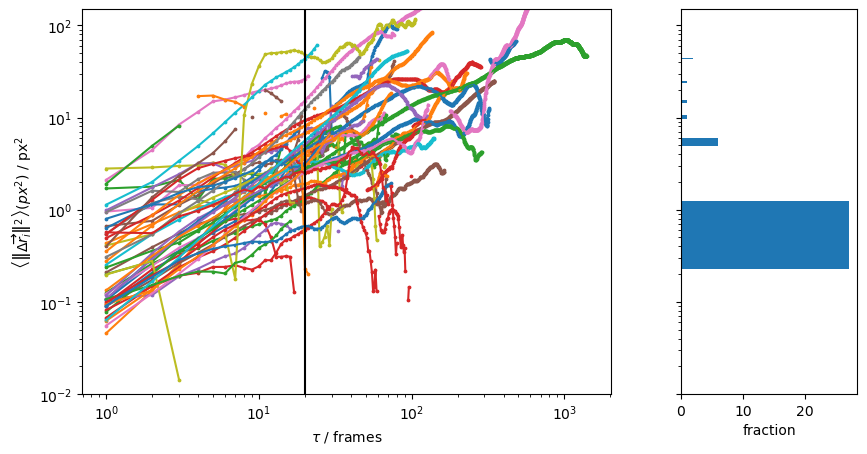

In [8]:
fig, axs = plt.subplots(1,2,figsize=(10,5),sharey=True,gridspec_kw={'width_ratios': [3, 1]})

msd_hist_values=[]

threshold=20

for track_id in tqdm(msd_results["track_id"].unique()):
    single_cell_df = msd_results.loc[msd_results["track_id"]==track_id]
    single_cell_df = single_cell_df.sort_values(by=["dt"])
    axs[0].scatter(single_cell_df['dt'], single_cell_df['msd'], label=track_id,s=3)
    axs[0].plot(single_cell_df['dt'], single_cell_df['msd'], label=track_id)
    axs[0].set_yscale("log")
    axs[0].set_xscale("log")
    if len(single_cell_df)>threshold:
        i=single_cell_df.loc[single_cell_df["dt"]==threshold,"msd"].values[0]
        msd_hist_values.append(i)
print(len(msd_hist_values))

msd_hist_values=[i for i in msd_hist_values if str(i) != 'nan']

axs[0].set_ylim(1e-2,1.5e2)
axs[0].vlines(threshold,1e-2,1.5e2,color='k')
H,B=np.histogram(msd_hist_values)
H_norm=H/len(msd_hist_values)
axs[1].barh(B[:-1],H,height=1,align='edge')
#axs[1].set_xlim(0,1)

axs[0].set_xlabel(r'$\tau$ / frames')
axs[0].set_ylabel(r'$\left\langle \left\| \Delta \overrightarrow{r}_i \right\|^2 \right\rangle (px^2)$ / px$^2$')
axs[1].set_xlabel(r'fraction')


### Displacement vs Travelled Distances

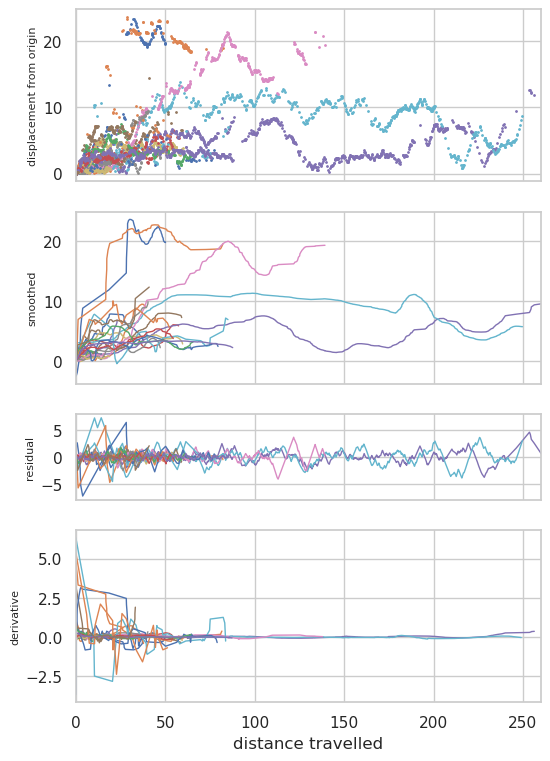

In [142]:
from tqdm import tqdm
from  scipy.signal import savgol_filter 

fig, axs = plt.subplots(4,1,figsize=(6,9),sharex=True,height_ratios=[2, 2,1,2])
#axs.set_xlim(0,100)
#axs.set_ylim(0,100)

# isolate one cell
TRACK_ID_TCELL = 37

for t_id in range(400,450):

    single_tcell_df = tracks_df_filtered_tcell.loc[tracks_df_filtered_tcell["track_id"]==t_id]
    single_tcell_df = single_tcell_df.sort_values(by=["frame"])
    data = single_tcell_df["displacement from origin"]
    if len(data) < 18:
        continue
    smooth = savgol_filter(data,mode="interp", window_length=int(len(data)/2)-1, polyorder=6)
    #smooth = savgol_filter(data,mode="interp", window_length=len(data)-1, polyorder=5)
    diff_tcell = np.diff(smooth)
    #diff_tcell.extend(diff_tcell[-1])


    axs[0].scatter(single_tcell_df["distance travelled"], single_tcell_df["displacement from origin"], s=1)
    #axs[0].set_xlabel("distance travelled")
    axs[0].set_ylabel("displacement from origin",fontsize=8)
    axs[0].set_xlim(0,260)

    axs[1].plot(single_tcell_df["distance travelled"], smooth, lw=1)
    #axs[1].set_xlabel("distance travelled")
    axs[1].set_ylabel("smoothed",fontsize=8)
    axs[1].set_xlim(0,260)

    axs[2].plot(single_tcell_df["distance travelled"], data-smooth, lw=1)
    #axs[1].set_xlabel("distance travelled")
    axs[2].set_ylabel("residual",fontsize=8)
    axs[2].set_xlim(0,260)

    axs[3].plot(single_tcell_df["distance travelled"][:-1], diff_tcell, lw=1)
    axs[3].set_xlabel("distance travelled")
    axs[3].set_ylabel("derivative",fontsize=8)
    axs[3].set_xlim(0,260)
    #axs[1].set_ylabel("displacement from origin")


# for t in tqdm(range(2000)):
#     single_tcell_df_ = single_tcell_df[single_tcell_df["frame"] == t]
#     single_tcell_df_.plot("distance travelled","displacement from origin",ax=axs,lw=0.2)

# axs.get_legend().remove()

### Speed 

In [37]:
tracks_df_filtered_tcell_ = tracks_df_filtered_tcell

tracks_df_filtered_tcell_

speed = tracks_df_filtered_tcell_.groupby(["track_id"])["speed"].mean()
pd.set_option("display.max_columns", None)
speed

track_id
1         0.185721
2         0.742700
3         1.761165
4         0.330685
6         0.373333
            ...   
294749    0.402463
294754    1.371887
294766    0.917476
294771    0.574999
294786    0.403389
Name: speed, Length: 130306, dtype: float64

In [31]:
tracks_df_filtered_tcell_speed = tracks_df_filtered_tcell_[tracks_df_filtered_tcell_["track_id"]==6]
tracks_df_filtered_tcell_speed

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,mean,median,sd,frame,channel,alive,pi_mean,pi_median,pi_std,corr_mean,corr_median,corr_std,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,dx from previous point,dy from previous point,displacement from previous point,dx from origin,dy from origin,displacement from origin,dx acc,dy acc,distance travelled,vel_x,vel_y,speed,average speed
2,1935,61.300000,11.933333,8,57,9,9,11.933333,61.300000,8.0,57.0,9.0,9.0,60.0,1.153715,1.153715,0.960884,9.219544,4.609772,28.576536,556612.0,9276.866667,8649.513672,2665.723602,0,tcell,NaN,2944.750000,2904.599609,54.361198,32763.733333,32650.320312,11.338948,6,1000019,0.307318,134,134,53.768657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.742700
7538,11664,61.075758,12.015152,8,57,9,9,12.015152,61.075758,8.0,57.0,9.0,9.0,66.0,1.097669,1.097669,0.962619,9.433981,4.716991,29.917295,595649.0,9024.984848,8857.435547,2460.082660,1,tcell,NaN,2942.378788,2893.378906,57.967302,32763.500000,32862.828125,13.266789,6,2000030,0.077258,134,134,53.768657,0.081818,-0.224242,0.238702,0.081818,-0.224242,0.238702,0.081818,0.224242,0.238702,0.081818,-0.224242,0.238702,0.690151
15140,21406,60.118421,12.000000,8,54,9,12,12.000000,60.118421,8.0,54.0,9.0,12.0,76.0,1.420303,1.420303,0.910553,11.704700,5.852350,33.939571,671320.0,8833.157895,9126.503906,2002.951176,2,tcell,NaN,2943.368421,2884.628906,59.762606,32765.605263,32692.300781,12.652356,6,3000020,0.118421,134,134,53.768657,-0.015152,-0.957337,0.957456,0.066667,-1.181579,1.183458,0.096970,1.181579,1.196159,-0.015152,-0.957337,0.957456,0.914135
22820,31675,60.108108,12.135135,8,54,9,12,12.135135,60.108108,8.0,54.0,9.0,12.0,74.0,1.402521,1.402521,0.898492,11.704700,5.852350,33.939571,643592.0,8697.189189,8857.435547,1831.109138,3,tcell,NaN,2940.581081,2902.207031,59.904492,32766.297297,32880.917969,10.481203,6,4000052,0.173057,134,134,53.768657,0.135135,-0.010313,0.135528,0.201802,-1.191892,1.208855,0.232105,1.191892,1.331687,0.135135,-0.010313,0.135528,NaN
30570,42029,60.225352,12.225352,8,55,9,11,12.225352,60.225352,8.0,55.0,9.0,11.0,71.0,1.311241,1.311241,0.900940,10.630146,5.315073,33.154172,618524.0,8711.605634,8735.619141,1852.252547,4,tcell,NaN,2934.549296,2992.613281,58.548829,32765.605634,32641.716797,11.785559,6,5001840,0.318696,134,134,53.768657,0.090217,0.117244,0.147937,0.292019,-1.074648,1.113617,0.322322,1.309136,1.479624,0.090217,0.117244,0.147937,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107151,1297546,60.636364,9.181818,5,57,9,8,9.181818,60.636364,5.0,57.0,9.0,8.0,55.0,1.354408,1.354408,0.945976,9.433981,4.716991,27.791138,519251.0,9440.927273,8901.216797,2275.998599,129,tcell,NaN,2979.127273,3007.939453,66.608045,32769.600000,32720.417969,2.469068,6,130000098,0.406558,134,134,53.768657,0.052189,-0.178451,0.185926,-2.751515,-0.663636,2.830415,29.453367,31.248359,47.803234,0.052189,-0.178451,0.185926,NaN
1115694,1307518,60.444444,9.055556,5,57,9,8,9.055556,60.444444,5.0,57.0,9.0,8.0,54.0,1.318424,1.318424,0.956449,8.944272,4.472136,27.235778,500992.0,9277.629630,9117.421875,2077.932248,130,tcell,NaN,2973.222222,3009.087891,61.392233,32770.074074,32779.628906,2.509242,6,131000113,0.447903,134,134,53.768657,-0.126263,-0.191919,0.229729,-2.877778,-0.855556,3.002263,29.579630,31.440278,48.032962,-0.126263,-0.191919,0.229729,NaN
1124254,1317347,60.200000,8.890909,5,57,9,7,8.890909,60.200000,5.0,57.0,9.0,7.0,55.0,1.327270,1.327270,0.993927,8.944272,4.472136,26.450380,505365.0,9188.454545,9126.503906,1941.931902,131,tcell,NaN,2971.327273,3023.496094,64.088785,32770.527273,32645.623047,2.478459,6,132000

In [29]:
#tracks_df_filtered_tcell_speed = tracks_df_filtered_tcell_.groupby(["track_id"])
tracks_df_filtered_tcell_speed = tracks_df_filtered_tcell_.sort_values(by=["track_id"])
pd.set_option("display.max_rows", 100)
tracks_df_filtered_tcell_speed.tail(50)

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,mean,median,sd,frame,channel,alive,pi_mean,pi_median,pi_std,corr_mean,corr_median,corr_std,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,dx from previous point,dy from previous point,displacement from previous point,dx from origin,dy from origin,displacement from origin,dx acc,dy acc,distance travelled,vel_x,vel_y,speed,average speed
13892559,16849690,713.733333,903.088889,900,710,10,9,903.088889,713.733333,900.0,710.0,10.0,9.0,45.0,1.410352,1.410352,0.760763,10.295630,5.147815,31.258054,374291.0,8317.577778,7982.998047,975.133522,1996,tcell,NaN,9608.266667,9244.976562,2369.590206,34760.000000,34017.707031,1800.651208,294754,1997029037,0.738701,12,21,89.750000,-0.291111,0.893333,0.939569,-3.186702,1.457743,3.504295,4.480055,5.346457,7.865745,-0.291111,0.893333,0.939569,NaN
13902696,16864170,715.239130,901.826087,899,710,8,10,901.826087,715.239130,899.0,710.0,8.0,10.0,46.0,1.152226,1.152226,0.803640,9.219544,4.609772,29.917295,395444.0,8596.608696,8234.560547,1125.601459,1998,tcell,NaN,10617.108696,10916.699219,2493.992464,35410.521739,34937.960938,2058.276450,294754,1999028646,6.607015,12,21,89.750000,-1.262802,1.505797,1.965221,-4.449504,2.963540,5.346087,5.742857,6.852254,9.830966,-0.631401,0.752899,0.982611,NaN
13907694,16870119,979.507463,966.477612,962,976,10,8,966.477612,979.507463,962.0,976.0,10.0,8.0,67.0,1.283351,1.283351,0.959451,10.000000,5.000000,30.242618,751030.0,11209.402985,10330.703125,3779.780321,1999,tcell,NaN,4216.805970,3736.996094,1137.879091,32755.358209,32729.095703,24.591019,294766,2000029820,0.696873,21,21,73.190476,-0.216833,0.285240,0.358299,-8.379531,1.614606,8.533668,15.076362,8.864913,19.267006,-0.216833,0.285240,0.358299,NaN
13902697,16862546,979.222222,966.694444,962,975,11,9,966.694444,979.222222,962.0,975.0,11.0,9.0,72.0,1.341661,1.341661,0.907263,10.630146,5.315073,33.154172,783527.0,10882.319444,10172.841797,3797.141853,1998,tcell,NaN,4101.680556,3597.988281,1123.450969,32757.638889,32718.851562,24.595491,294766,1999029802,0.377819,21,21,73.190476,-0.091270,0.065079,0.112096,-8.162698,1.329365,8.270239,14.859529,8.579672,18.908707,-0.091270,0.065079,0.112096,NaN
13839413,16775106,979.417910,966.119403,962,975,10,9,966.119403,979.417910,962.0,975.0,10.0,9.0,67.0,1.233125,1.233125,0.969884,9.848858,4.924429,29.917295,762225.0,11376.492537,10279.160156,3757.652202,1986,tcell,NaN,4137.985075,3644.453125,1110.926197,32755.164179,32730.671875,25.186334,294766,1987029607,0.434633,21,21,73.190476,1.109403,1.757910,2.078707,-8.737740,1.525053,8.869830,11.677961,4.547139,13.631343,1.109403,1.757910,2.078707,NaN
13887430,16839970,977.310000,965.320000,960,971,12,13,965.320000,977.310000,960.0,971.0,12.0,13.0,100.0,1.700814,1.700814,0.865272,14.212670,7.106335,40.968686,1068732.0,10687.320000,9862.423828,3747.187052,1995,tcell,NaN,3904.800000,3613.175781,923.452886,32761.320000,32749.750000,20.779691,294766,1996029599,2.382960,21,21,73.190476,-1.040000,-1.490000,1.817058,-9.537143,-0.582857,9.554937,13.302545,6.667450,16.424222,-1.040000,-1.490000,1.817058,NaN
13811165,16738088,979.123288,965.643836,961,975,10,9,965.643836,979.123288,961.0,975.0,10.0,9.0,73.0,1.116046,1.116046,0.993931,9.848858,4.924429,30.472655,849380.0,11635.342466,10615.828125,4125.375378,1981,tcell,NaN,4102.657534,3663.212891,1024.293472,32755.972603,32739.318359,24.361840,294766,1982029817,0.655533,21,21,73.190476,0.184376,0.055720,0.192612,-9.213307,1.230431,9.295106,9.582060,1.230431,9.663430,0.184376,0.055720,0.192612,NaN
13871843,16818995,979.060606,966.424242,962,975,10,9,966.424242,979.060606,962.0,975.0,10.0,9.0,66.0,1.279765,1.279765,0.962619,9.486833,4.743416,29.917295,711762.0,10784.272727,9828.357422,3440.464810,1992,tcell,NaN,4084.712121,3665.634766,1097.921361,32756.727273,32750.693359,24.761350,294

/tmp/ipykernel_1753544/1038129259.py:22: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[0].set_xlim([0,10])
/tmp/ipykernel_1753544/1038129259.py:59: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[1].set_xlim([0,10])


0.024388940535494886 0.21886892566298008


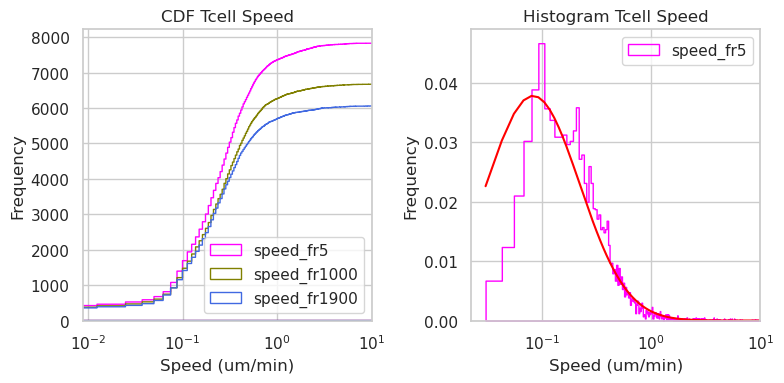

In [230]:
import seaborn as sns
from scipy import stats

tracks_df_filtered_tcell_speed_5 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==5]
tracks_df_filtered_tcell_speed_1000 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==1000]
tracks_df_filtered_tcell_speed_1500 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==1900]

# Plot tcell histogram
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.set(style='whitegrid')
sns.histplot(data=tracks_df_filtered_tcell_speed_5, x='speed', bins=1000, kde=False, edgecolor='magenta', label='speed_fr5', stat="frequency", element="step",common_norm=False, cumulative=True,alpha=0,ax=axes[0])
sns.histplot(data=tracks_df_filtered_tcell_speed_1000, x='speed', bins=1000, kde=False, edgecolor='olive', label='speed_fr1000',stat="frequency",element="step",common_norm=False,cumulative=True,alpha=0,ax=axes[0])
sns.histplot(data=tracks_df_filtered_tcell_speed_1500, x='speed', bins=1000, kde=False, edgecolor='royalblue', label='speed_fr1900', stat="frequency", element="step",common_norm=False,cumulative=True, alpha=0,ax=axes[0])
axes[0].set_title('CDF Tcell Speed')
axes[0].set_xlabel("Speed (um/min)")
tickpos=[1e-2,1e-1,1e0,1e1]
ticklabel = [t*1.6*10.0/60. for t in tickpos]

axes[0].set_xticks(tickpos,ticklabel)
axes[0].set_ylabel("Frequency")
axes[0].set_xscale("log")
axes[0].set_xlim([0,10])
axes[0].legend(loc=4)
plt.tight_layout()

# sns.histplot(data=tracks_df_filtered_tcell_speed_5, x='speed', bins=1000, kde=False, edgecolor='magenta', label='speed_fr5', stat="probability", element="step",common_norm=False, cumulative=False,alpha=0,ax=axes[1])
# sns.histplot(data=tracks_df_filtered_tcell_speed_1000, x='speed', bins=1000, kde=False, edgecolor='olive', label='speed_fr1000',stat="probability",element="step",common_norm=False,cumulative=False,alpha=0,ax=axes[1])
# sns.histplot(data=tracks_df_filtered_tcell_speed_1500, x='speed', bins=1000, kde=False, edgecolor='royalblue', label='speed_fr1900', stat="probability", element="step",common_norm=False,cumulative=False, alpha=0,ax=axes[1])
axes[1].set_title('Histogram Tcell Speed')
axes[1].set_xlabel("Speed (um/min)")

fit_y=tracks_df_filtered_tcell_speed_1500['speed']
fit_y= fit_y[fit_y>3e-2]
sns.histplot(data=fit_y, bins=1000, kde=False, edgecolor='magenta', label='speed_fr5', stat="probability", element="step",common_norm=False, cumulative=False,alpha=0,ax=axes[1])
H,B=np.histogram(fit_y, bins=1000)
# H_norm=H/np.sum(H)
# mean, var, skew, kurt = stats.lognorm.stats(fit_y,moments="mvsk")
# print(
#     "mean: ",mean,
#     "var: ", var,
#     "skew: ", skew,
#     "kurt: ",kurt
# )
sigma,loc,exp_mu=stats.lognorm.fit(fit_y,method='MLE')
mu = np.log(exp_mu)
# x = np.linspace(1e-2,1e1,2000)
x = B
print(loc,exp_mu)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))/ (x * sigma * np.sqrt(2 * np.pi)))
pdf = pdf/np.sum(pdf)
axes[1].plot(x,pdf,color="red")

# tickpos=[1e-2,1e-1,1e0,1e1]
# ticklabel = [t*1.6*10.0/60. for t in tickpos]

# axes[1].set_xticks(tickpos,ticklabel)
axes[1].set_ylabel("Frequency")
axes[1].set_xscale("log")
axes[1].set_xlim([0,10])
axes[1].legend(loc=1)
plt.tight_layout()

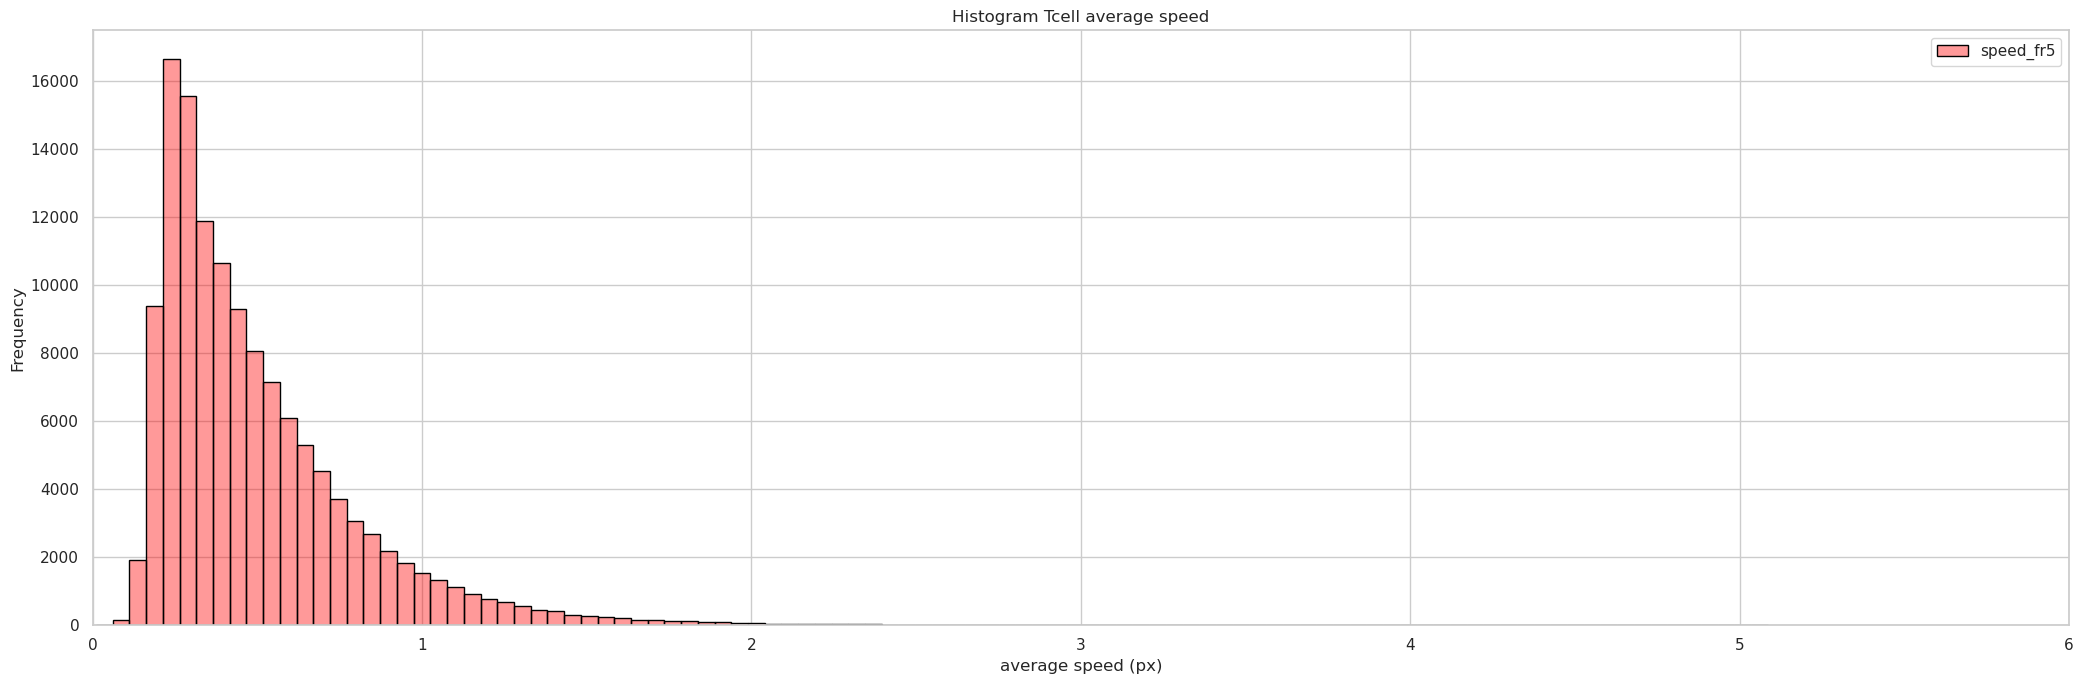

In [22]:
import seaborn as sns

tracks_df_filtered_tcell_speed = tracks_df_filtered_tcell_.sort_values(by=["track_id"])


# Plot tcell histogram
fig, axes = plt.subplots(1, 1, figsize=(21, 7))
sns.set(style='whitegrid')
#axes = axes.flatten()
sns.histplot(data=tracks_df_filtered_tcell_speed, x='average speed', bins=100, kde=False, color='red', edgecolor='black', label='speed_fr5', alpha=0.4)
#sns.histplot(data=tracks_df_filtered_tcell_speed_1000, x='speed', bins=100, kde=False, color='blue', edgecolor='black', label='speed_fr1000',alpha=0.4)
#sns.histplot(data=tracks_df_filtered_tcell_speed_1500, x='speed', bins=100, kde=False, color='green', edgecolor='black', label='speed_fr1900',alpha=0.4)
axes.set_title('Histogram Tcell average speed')
axes.set_xlabel("average speed (px)")
axes.set_ylabel("Frequency")
#axes[0].set_yscale("log")
axes.set_xlim([0,6])
axes.legend()
plt.tight_layout()

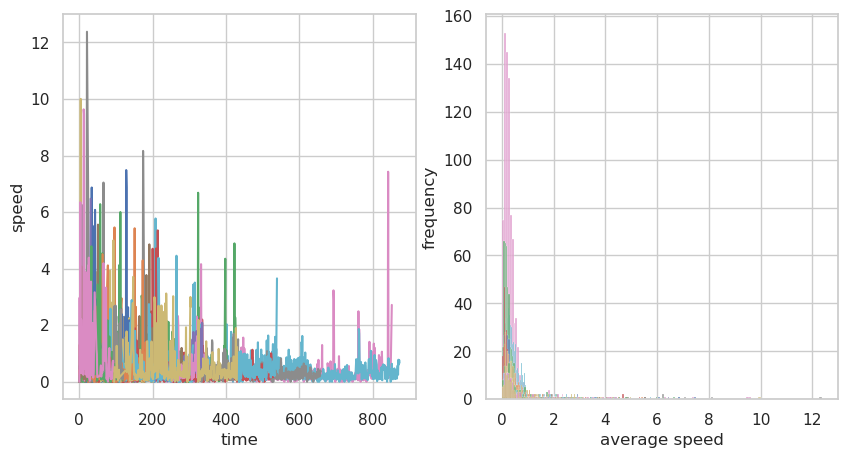

In [44]:
from tqdm import tqdm
import seaborn as sns

fig, axs = plt.subplots(1,2,figsize=(10,5))
#axs.set_xlim(0,100)
#axs.set_ylim(0,100)


#tracks_df_filtered_tcell["dy from origin"] = tracks_df_filtered_tcell.groupby(['track_id'])['dy from previous point'].cumsum().fillna(0)

# isolate one cell
TRACK_ID_TCELL = 37

for t_id in range(400,500):

    single_tcell_df = tracks_df_filtered_tcell_.loc[tracks_df_filtered_tcell_["track_id"]==t_id]
    single_tcell_df = single_tcell_df.sort_values(by=["frame"])

    axs[0].plot(single_tcell_df["frame"], single_tcell_df["speed"])
    axs[0].set_xlabel("time")
    axs[0].set_ylabel("speed")

    sns.histplot(data=single_tcell_df, x='speed', bins=100, ax=axs[1])
    axs[1].set_xlabel("average speed")
    axs[1].set_ylabel("frequency")

In [22]:
single_tcell_df = tracks_df_filtered_tcell_.loc[tracks_df_filtered_tcell_["track_id"]==500]
single_tcell_df = single_tcell_df.sort_values(by=["frame"])
single_tcell_df["average speed"] = single_tcell_df["speed"].mean()
single_tcell_df[["tracked frames","tracked length","dt acc", "speed", "average speed"]]

,tracked frames,tracked length,dt acc,speed,average speed
2592830,19,30,0,0.000000,0.906021
2601049,19,30,1,0.259392,0.906021
2609248,19,30,2,0.515832,0.906021
2617471,19,30,3,0.178290,0.906021
2625685,19,30,4,3.123081,0.906021
2633908,19,30,5,0.351080,0.906021
2642120,19,30,6,0.351988,0.906021
2650326,19,30,7,0.311511,0.906021
2658508,19,30,8,0.148600,0.906021
2666672,19,30,9,0.249459,0.906021


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


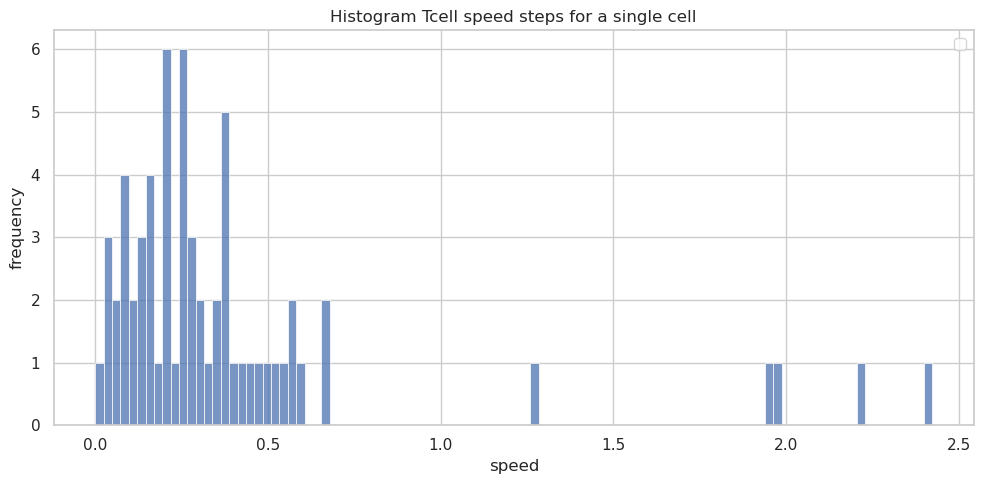

In [43]:
import seaborn as sns

single_tcell_df = tracks_df_filtered_tcell_.loc[tracks_df_filtered_tcell_["track_id"]==300]
single_tcell_df = single_tcell_df.sort_values(by=["frame"])

# Plot tcell histogram
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
#axes = axes.flatten()
sns.histplot(data=single_tcell_df, x='speed', bins=100)
axes.set_title('Histogram Tcell speed steps for a single cell')
axes.set_xlabel("speed")
axes.set_ylabel("frequency")
#axes[0].set_yscale("log")
axes.legend()
plt.tight_layout()


### Displacement and distance travelled ensemble histograms for T cells and Cancer Cells

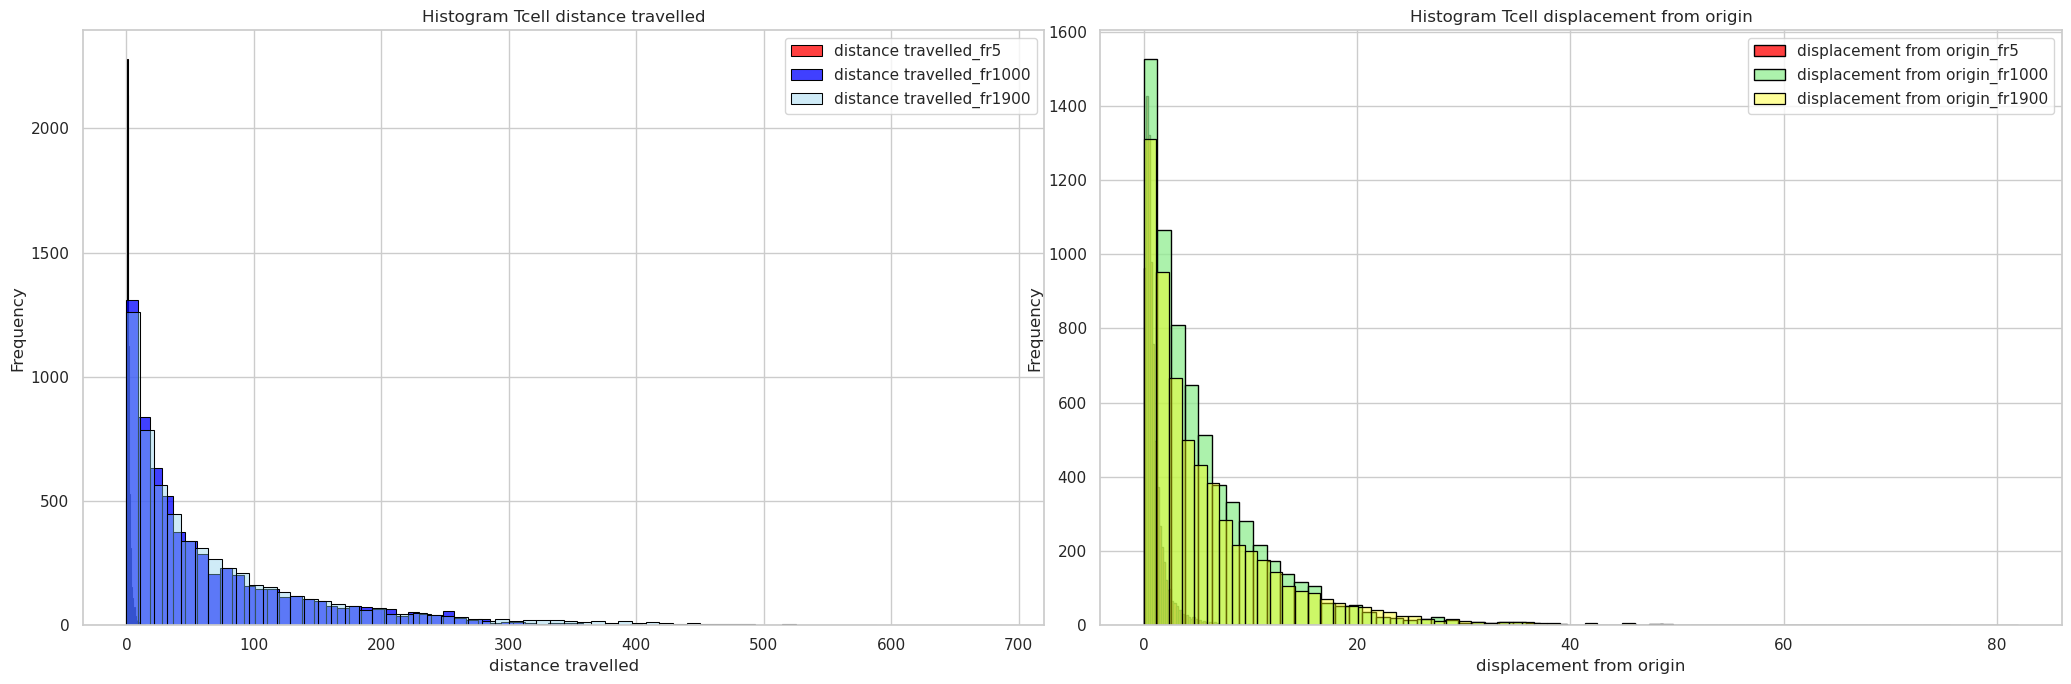

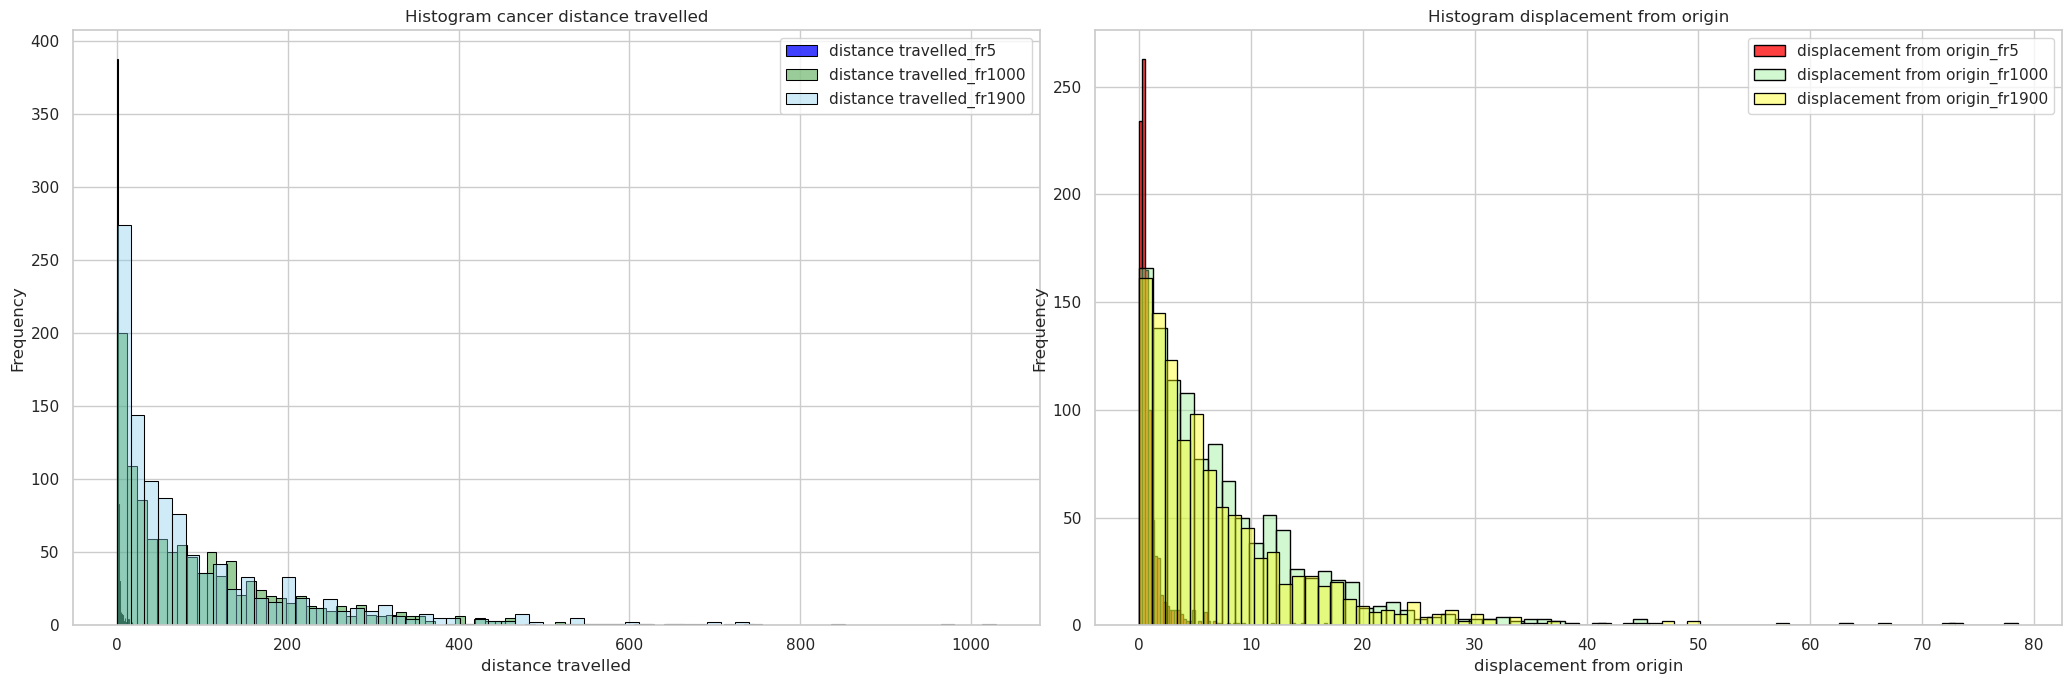

In [ ]:
import seaborn as sns

#axs.set_xlim(0,3)
#axs.set_ylim(0,125)
# Set Seaborn style
sns.set(style='whitegrid')

tracks_df_filtered_tcell_bright_5 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==5]
tracks_df_filtered_tcell_bright_1000 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==1000]
tracks_df_filtered_tcell_bright_1500 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==1900]

tracks_df_filtered_tcell_corr_5 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==5]
tracks_df_filtered_tcell_corr_1000 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==1000]
tracks_df_filtered_tcell_corr_1500 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==1900]


tracks_df_filtered_cancer_bright_5 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==5]
tracks_df_filtered_cancer_bright_1000 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==1000]
tracks_df_filtered_cancer_bright_1500 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==1900]

tracks_df_filtered_cancer_corr_5 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==5]
tracks_df_filtered_cancer_corr_1000 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==1000]
tracks_df_filtered_cancer_corr_1500 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==1900]



# Plot tcell histogram
fig, axes = plt.subplots(1, 2, figsize=(21, 7))
axes = axes.flatten()
sns.histplot(data=tracks_df_filtered_tcell_bright_5, x='distance travelled', bins=64, kde=False, color='red', edgecolor='black',ax=axes[0], label='distance travelled_fr5')
sns.histplot(data=tracks_df_filtered_tcell_bright_1000, x='distance travelled', bins=64, kde=False, color='blue', edgecolor='black',ax=axes[0], label='distance travelled_fr1000')
sns.histplot(data=tracks_df_filtered_tcell_bright_1500, x='distance travelled', bins=64, kde=False, color='skyblue', edgecolor='black', label='distance travelled_fr1900',ax=axes[0],alpha=0.4)
axes[0].set_title('Histogram Tcell distance travelled')
axes[0].set_xlabel("distance travelled")
axes[0].set_ylabel("Frequency")
#axes[0].set_yscale("log")
axes[0].legend()
plt.tight_layout()

# Plot a histogram
sns.histplot(data=tracks_df_filtered_tcell_bright_5, x='displacement from origin', bins=64, kde=False, color='red', edgecolor='black', ax=axes[1],label='displacement from origin_fr5')
sns.histplot(data=tracks_df_filtered_tcell_bright_1000, x='displacement from origin', bins=64, kde=False, color='lightgreen', edgecolor='black', ax=axes[1],label='displacement from origin_fr1000')
sns.histplot(data=tracks_df_filtered_tcell_bright_1500, x='displacement from origin', bins=64, kde=False, color="yellow", edgecolor='black', ax=axes[1], label='displacement from origin_fr1900', alpha=0.4)
axes[1].set_title('Histogram Tcell displacement from origin')
axes[1].set_xlabel("displacement from origin")
axes[1].set_ylabel("Frequency")
#axes[1].set_yscale("log")
axes[1].legend()

# # Plot a histogram
# sns.histplot(data=tracks_df_filtered_tcell_corr_5, x='corr_mean', bins=64, kde=False, color='red', edgecolor='black', ax=axes[2],label='corr_mean_fr5')
# sns.histplot(data=tracks_df_filtered_tcell_corr_1000, x='corr_mean', bins=64, kde=False, color='lightgreen', edgecolor='black', ax=axes[2],label='corr_mean_fr1000')
# sns.histplot(data=tracks_df_filtered_tcell_corr_1500, x='corr_mean', bins=64, kde=False, color="yellow", edgecolor='black', ax=axes[2], label='corr_mean_fr1900', alpha=0.4)
# axes[2].set_title('Histogram Tcell corr')
# axes[2].set_xlabel("Mean Corr brightness")
# axes[2].set_ylabel("Frequency")
# axes[2].set_yscale("log")
# axes[2].set_xlim([32000,44000])
# axes[2].legend()

# plt.tight_layout()


#### Plot cancer histogram
fig, axes = plt.subplots(1, 2, figsize=(21, 7))
axes = axes.flatten()
sns.histplot(data=tracks_df_filtered_cancer_bright_5, x='distance travelled', bins=64, kde=False, color='blue', edgecolor='black', label='distance travelled_fr5', ax=axes[0])
sns.histplot(data=tracks_df_filtered_cancer_bright_1000, x='distance travelled', bins=64, kde=False, color='green', edgecolor='black', label='distance travelled_fr1000',alpha=0.4, ax=axes[0])
sns.histplot(data=tracks_df_filtered_cancer_bright_1500, x='distance travelled', bins=64, kde=False, color='skyblue', edgecolor='black', label='distance travelled_fr1900', alpha=0.4,ax=axes[0])
axes[0].set_title('Histogram cancer distance travelled')
axes[0].set_xlabel("distance travelled")
axes[0].set_ylabel("Frequency")
#axes[0].set_yscale("log")
axes[0].legend()
plt.tight_layout()

# Plot a histogram
sns.histplot(data=tracks_df_filtered_cancer_bright_5, x='displacement from origin', bins=64, kde=False, color='red', edgecolor='black', label='displacement from origin_fr5', ax=axes[1])
sns.histplot(data=tracks_df_filtered_cancer_bright_1000, x='displacement from origin', bins=64, kde=False, color='lightgreen', edgecolor='black', label='displacement from origin_fr1000',alpha=0.4, ax=axes[1])
sns.histplot(data=tracks_df_filtered_cancer_bright_1500, x='displacement from origin', bins=64, kde=False, color='yellow', edgecolor='black', label='displacement from origin_fr1900', alpha=0.4,ax=axes[1])
axes[1].set_title('Histogram displacement from origin')
axes[1].set_xlabel("displacement from origin")
axes[1].set_ylabel("Frequency")
#axes[1].set_yscale("log")
axes[1].legend()

# # Plot a histogram
# sns.histplot(data=tracks_df_filtered_cancer_corr_5, x='corr_mean', bins=64, kde=False, color='red', edgecolor='black', ax=axes[2],label='corr_mean_fr5')
# sns.histplot(data=tracks_df_filtered_cancer_corr_1000, x='corr_mean', bins=64, kde=False, color='lightgreen', edgecolor='black', ax=axes[2],label='corr_mean_fr1000')
# sns.histplot(data=tracks_df_filtered_cancer_corr_1500, x='corr_mean', bins=64, kde=False, color="yellow", edgecolor='black', ax=axes[2], label='corr_mean_fr1900', alpha=0.4)
# axes[2].set_title('Histogram Tcell corr')
# axes[2].set_xlabel("Mean Corr brightness")
# axes[2].set_ylabel("Frequency")
# axes[2].set_yscale("log")
# axes[2].set_xlim([32000,44000])
# axes[2].legend()



# plt.tight_layout()


Plot tracks in space centered at their initial position 

In [ ]:
def plot_tracks(tracks_df: pd.DataFrame) -> None:
    """Center tracks at their initial position and plot them.

    Parameters
    ----------
    tracks_df : pd.DataFrame
        Tracks datafarame sorted by `track_id` and `t`.

    Returns
    -------
    pd.DataFrame
        Centered dataframe.
    """
    centered_df = tracks_df.copy()
    centered_df[["y", "x"]] = centered_df.groupby(
        "track_id",
        as_index=False,
    )[["y", "x"]].transform(lambda x: x - x.iloc[0])

    # sanity check
    assert (centered_df[centered_df["frame"] == 0][["y", "x"]] == 0).all().all()

    pallete = sns.color_palette(["gray"], len(centered_df["track_id"].unique()))
    sns.lineplot(
        data=centered_df,
        x="x",
        y="y",
        hue="track_id",
        palette=pallete,
        legend=False,
        alpha=0.5,
        sort=False,
        estimator=None,
    )

    return centered_df

In [ ]:
import seaborn as sns
plot_tracks(msd_df)

Plot tracks in space

In [ ]:
track_id = 10

fig, axs = plt.subplots(1,1,figsize=(10,5))

for t_id in tqdm(range(2000)):
    single_cell_df = msd_df.loc[msd_df["track_id"]==t_id]
    single_cell_df = single_cell_df.sort_values(by=["frame"])
    axs.plot(single_cell_df['x'], single_cell_df['y'], label=track_id)